In [1]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt

https://www.gymlibrary.dev/environments/classic_control/mountain_car/

The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill. There are two versions of the mountain car domain in gym: one with discrete actions and one with continuous. This version is the one with discrete actions.

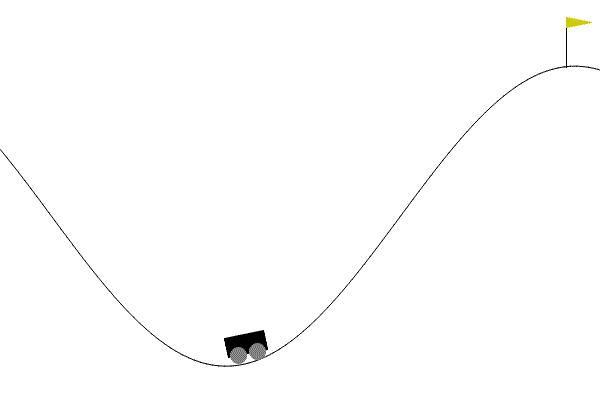

In [2]:
env = gym.make('MountainCar-v0')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.n)

[0.6  0.07]
[-1.2  -0.07]
3


The observation space is a continuous range of values. It is often useful to simplify the problem and discretize the space. Hence, by having fewer states and transitions, it is easier to converge to a solution.

We will divide the space into a 20x20 matrix, where each cell represents a state. The state transitions are determined by the environment - all the agent can do is take one of the possible actions (accelerate left, do not accelerate or accelerate right) and observe reward. It is not required to define terminal state because the environment will inform when it is reached, alongside all other termination conditions.

Of course not all states will be reachable, so this solution is not optimal since we waste resources. On the other hand, it can be used in any 2D space.

In [16]:
# Hyper-parameters

DISCRETE_BUCKETS = 20
EPISODES = 10000
DISCOUNT = 0.95
EPISODE_DISPLAY = 500
LEARNING_RATE = 0.1
EPSILON = 0.5
EPSILON_DECREMENTER = EPSILON/(EPISODES//4)

In [17]:
def discretised_state(state):
	"""
	Auxiliary function used to convert from real valued observation space into discretized space.
	state: list of two values, respectivelly car position in x-axis and velocity
	"""
	observation_space_range = env.observation_space.high - env.observation_space.low
	discrete_cell_size = observation_space_range/[DISCRETE_BUCKETS]*len(env.observation_space.high)
	discrete_state = (state-env.observation_space.low)//discrete_cell_size
	return tuple(discrete_state.astype(int))

def print_stats(rew, ep):
	avg_reward = sum(rew[-EPISODE_DISPLAY:])/len(rew[-EPISODE_DISPLAY:])
	ep_rewards_table['ep'].append(ep)
	ep_rewards_table['avg'].append(avg_reward)
	ep_rewards_table['min'].append(min(rew[-EPISODE_DISPLAY:]))
	ep_rewards_table['max'].append(max(rew[-EPISODE_DISPLAY:]))

	print(f"Episode:{ep} avg:{avg_reward} min:{min(rew[-EPISODE_DISPLAY:])} max:{max(rew[-EPISODE_DISPLAY:])}")

SARSA

In [19]:
# create environment
env = gym.make('MountainCar-v0')

# initialize variables
Q_TABLE = np.random.randn(DISCRETE_BUCKETS,DISCRETE_BUCKETS,env.action_space.n)
ep_rewards = []
ep_rewards_table = {'ep': [], 'avg': [], 'min': [], 'max': []}

for episode in range(EPISODES):

	episode_reward = 0
	done = False

	# convert initial state into discrete state
	curr_discrete_state = discretised_state(env.reset())

	# sample an action using epsilon-greedy
	if np.random.random() > EPSILON:
		action = np.argmax(Q_TABLE[curr_discrete_state])
	else:
		action = np.random.randint(0, env.action_space.n)

	# repeat until episode ends
	while not done:

		# evaluate selected action and obtain new state
		new_state, reward, done, _ = env.step(action)
		new_discrete_state = discretised_state(new_state)

		# repeat sampling procedure
		if np.random.random() > EPSILON:
			new_action = np.argmax(Q_TABLE[new_discrete_state])
		else:
			new_action = np.random.randint(0, env.action_space.n)

		# check if terminal conditions were reached
		if not done:
			# SARSA update formula
			current_q = Q_TABLE[curr_discrete_state + (action,)]
			max_future_q = Q_TABLE[new_discrete_state + (new_action,)]
			Q_TABLE[curr_discrete_state+(action,)] = current_q + LEARNING_RATE * (reward+DISCOUNT*max_future_q-current_q)
		elif new_state[0] >= env.goal_position:
			Q_TABLE[curr_discrete_state + (action,)] = 0

		# setting up vars for next iterations (new action becomes old)
		curr_discrete_state = new_discrete_state
		action = new_action

		episode_reward += reward

	# decrease exploration rate as number of episodes increases to help converge faster
	EPSILON = EPSILON - EPSILON_DECREMENTER

	ep_rewards.append(episode_reward)

	# print stats at every EPISODE_DISPLAY
	if not episode % EPISODE_DISPLAY:
		print_stats(ep_rewards, episode)

env.close()

Episode:0 avg:-200.0 min:-200.0 max:-200.0
Episode:500 avg:-200.0 min:-200.0 max:-200.0
Episode:1000 avg:-199.448 min:-200.0 max:-154.0
Episode:1500 avg:-194.316 min:-200.0 max:-144.0
Episode:2000 avg:-189.454 min:-200.0 max:-143.0
Episode:2500 avg:-189.012 min:-200.0 max:-112.0
Episode:3000 avg:-184.288 min:-200.0 max:-108.0
Episode:3500 avg:-176.502 min:-200.0 max:-109.0
Episode:4000 avg:-158.448 min:-200.0 max:-119.0
Episode:4500 avg:-141.224 min:-194.0 max:-119.0
Episode:5000 avg:-138.24 min:-200.0 max:-117.0
Episode:5500 avg:-137.41 min:-200.0 max:-117.0
Episode:6000 avg:-137.004 min:-200.0 max:-117.0
Episode:6500 avg:-137.912 min:-200.0 max:-117.0
Episode:7000 avg:-136.33 min:-200.0 max:-117.0
Episode:7500 avg:-138.212 min:-200.0 max:-117.0
Episode:8000 avg:-137.646 min:-200.0 max:-117.0
Episode:8500 avg:-139.912 min:-200.0 max:-117.0
Episode:9000 avg:-137.574 min:-200.0 max:-117.0
Episode:9500 avg:-136.962 min:-200.0 max:-117.0


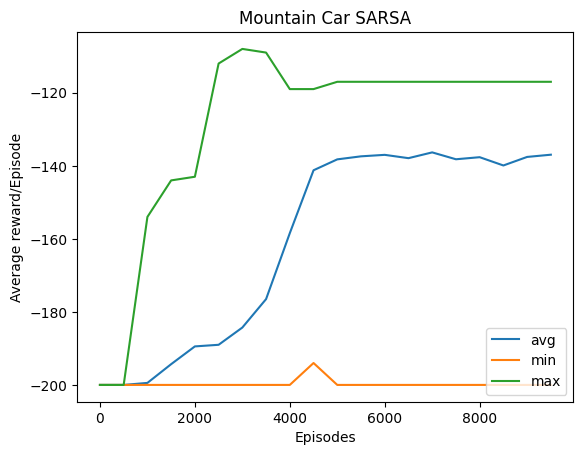

In [20]:
def plot_rewards(rew, type):
  plt.plot(rew['ep'], rew['avg'], label="avg")
  plt.plot(rew['ep'], rew['min'], label="min")
  plt.plot(rew['ep'], rew['max'], label="max")
  plt.legend(loc=4) #bottom right
  plt.title('Mountain Car ' + type)
  plt.ylabel('Average reward/Episode')
  plt.xlabel('Episodes')
  plt.show()

plot_rewards(ep_rewards_table, "SARSA")

Q-LEARNING

In [21]:
# create environment
env = gym.make('MountainCar-v0')

# initialize variables
Q_TABLE = np.random.randn(DISCRETE_BUCKETS,DISCRETE_BUCKETS,env.action_space.n)
ep_rewards = []
ep_rewards_table = {'ep': [], 'avg': [], 'min': [], 'max': []}

for episode in range(EPISODES):

	episode_reward = 0
	done = False

	# convert initial state into discrete state
	curr_discrete_state = discretised_state(env.reset())

	# sample an action using epsilon-greedy
	if np.random.random() > EPSILON:
		action = np.argmax(Q_TABLE[curr_discrete_state])
	else:
		action = np.random.randint(0, env.action_space.n)

	# repeat until episode ends
	while not done:

		# evaluate selected action and obtain new state
		new_state, reward, done, _ = env.step(action)
		new_discrete_state = discretised_state(new_state)

		# repeat sampling procedure
		if np.random.random() > EPSILON:
			new_action = np.argmax(Q_TABLE[new_discrete_state])
		else:
			new_action = np.random.randint(0, env.action_space.n)

		# check if terminal conditions were reached
		if not done:
			# Q-LEARNING update formula
			current_q = Q_TABLE[curr_discrete_state + (action,)]
			max_future_q = np.max(Q_TABLE[new_discrete_state])
			Q_TABLE[curr_discrete_state+(action,)] = current_q + LEARNING_RATE * (reward+DISCOUNT*max_future_q-current_q)
		elif new_state[0] >= env.goal_position:
			Q_TABLE[curr_discrete_state + (action,)] = 0

		# setting up vars for next iterations (new action becomes old)
		curr_discrete_state = new_discrete_state
		action = new_action

		episode_reward += reward

	# decrease exploration rate as number of episodes increases to help converge faster
	EPSILON = EPSILON - EPSILON_DECREMENTER

	ep_rewards.append(episode_reward)

	# print stats at every EPISODE_DISPLAY
	if not episode % EPISODE_DISPLAY:
		print_stats(ep_rewards, episode)

env.close()

Episode:0 avg:-200.0 min:-200.0 max:-200.0
Episode:500 avg:-191.378 min:-200.0 max:-112.0
Episode:1000 avg:-178.078 min:-200.0 max:-112.0
Episode:1500 avg:-145.164 min:-200.0 max:-88.0
Episode:2000 avg:-128.536 min:-200.0 max:-88.0
Episode:2500 avg:-127.134 min:-200.0 max:-88.0
Episode:3000 avg:-127.194 min:-200.0 max:-88.0
Episode:3500 avg:-131.252 min:-200.0 max:-87.0
Episode:4000 avg:-165.614 min:-200.0 max:-104.0
Episode:4500 avg:-159.512 min:-200.0 max:-86.0
Episode:5000 avg:-155.61 min:-200.0 max:-85.0
Episode:5500 avg:-148.872 min:-200.0 max:-107.0
Episode:6000 avg:-147.266 min:-173.0 max:-107.0
Episode:6500 avg:-147.764 min:-168.0 max:-107.0
Episode:7000 avg:-146.658 min:-168.0 max:-107.0
Episode:7500 avg:-145.426 min:-168.0 max:-107.0
Episode:8000 avg:-144.686 min:-168.0 max:-107.0
Episode:8500 avg:-145.154 min:-168.0 max:-107.0
Episode:9000 avg:-144.22 min:-168.0 max:-107.0
Episode:9500 avg:-144.788 min:-168.0 max:-107.0


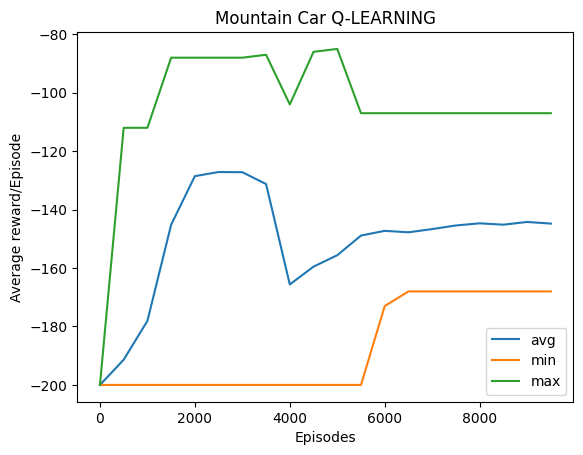

In [22]:
plot_rewards(ep_rewards_table, "Q-LEARNING")